In [1]:
import numpy as np
# threshold : 1개의 배열당 총 element 개수, linewidth : 1줄당 문자 수
np.set_printoptions(threshold=np.inf, linewidth=np.inf) 

import pandas as pd
pd.set_option('display.max_row', 70000000)
pd.set_option('display.max_column', 10000)
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical

import sqlite3

import glob
import os
import datetime
# Log Data가 저장될 디렉터리 경로 만들기
dir_name = "Learning_log"

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name)
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, sub_dir_name)

import csv

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## 초당 주행기록 가져오기
    1. %EventCode03_start - 6sec <= srcrec < %EventCode03_start : event03이 일어나기 직전의 주행기록
    2. 나머지 시간의 srcrec 

In [2]:
path = "tmp/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
print ("file_list: {}".format(file_list_db))

# EventCode03이 일어났을 당시의 초당 주행기록 가져오기
srcrec_df2 = pd.DataFrame() #연결한 db 결과 저장소
for i in range (0,len(file_list_db)):
    f = open('src/event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f) 
    # db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # 자신의 주행기록에서 발생한 event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일에서 자신의 주행기록에서 발생한 event만 추출해 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY, EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        # key를 추출해서 자신의 주행기록이 아니면 pass
        if key != int(file_list_db[i][4:11]): # src에 자신의 db파일이 있어야함, 경로가 다르면 인덱스 수정할 것
            continue
        code = (row[7])
        # event03 추출
        if code[-11:] != "EventCode03" and code[-11:] != "EventCode02" and code[-11:] != "EventCode10":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    # 트랜잭션 저장
    conn.commit()
    
    # event03이 일어나기 전의 주행기록과 그 밖의 주행기록을 분리하는 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, ifnull(EVENT_CODE, "0") AS EVENT_CODE FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s,"-6 seconds")\
     AND strftime("%Y%m%d%H%M%S",e)\
    EXCEPT \
    SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, EVENT_CODE FROM SRCREC LEFT JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    #db 파일 연결 작업
    srcrec_df2 = pd.concat([srcrec_df2, srcrec_df], ignore_index=True)
    #db 연결 종료
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
srcrec_df = srcrec_df2

file_list: ['tmp\\2859375.db', 'tmp\\2859393.db', 'tmp\\2859490.db', 'tmp\\2859493.db', 'tmp\\2859498.db', 'tmp\\2859511.db', 'tmp\\2860402.db', 'tmp\\2860462.db', 'tmp\\2860759.db', 'tmp\\2860884.db']


## event03이 일어난 데이터와 그 밖의 데이터 비율 1:1로 맞추기

In [3]:
# event03 데이터 가져오기
srcevent03_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('03')]
# event02데이터 가져오기
srcevent02_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('02')]
# event10데이터 가져오기
srcevent10_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('10')]

# event03 + event02 + event10 데이터 수만큼 비율 맞춰서 sampling
len_srcevent = len(srcevent03_df.index) + len(srcevent02_df.index) + len(srcevent10_df.index)
srcnor_df = srcrec_df[srcrec_df['EVENT_CODE']=='0'].sample(len_srcevent)
len_srcnor = len(srcnor_df.index)

# event03, event02이 일어난 데이터와 그 밖의 데이터 합치기
srcrec_df = pd.concat([srcevent03_df, srcnor_df])
srcrec_df = pd.concat([srcevent02_df, srcrec_df])
srcrec_df = pd.concat([srcevent10_df, srcrec_df])

# 더 정확한 예측을 위해 주행기록을 시간순으로 정렬
srcrec_df= srcrec_df.sort_values(by=['realTime'], axis=0,ascending=True)
srcrec_df

print(len(srcevent03_df.index))
print(len(srcevent02_df.index))
print(len(srcevent10_df.index))
print(len(srcrec_df.index))

946
763
428
4274


## 주행기록을 x data와 y data로 나누기
* x data : 차량주행데이터
* y data : 이벤트 종류(%EventCode03_start-6sec < srcrec < %EventCode03_start = 1 or 나머지 = 0)

In [4]:
x_data = srcrec_df.apply(pd.to_numeric, errors='coerce')
x_data = x_data.iloc[:,2:8] # srcSpeed ~ srcIntakeAirTemp
x_data = x_data.values
#x_data

In [5]:
y_data = srcrec_df.values[:,9] # EVENT_CODE
y_data = pd.get_dummies(y_data).values
y_data_temp = y_data.copy()

# normal 
temp = y_data[:,0] 

where_1 = np.where(temp == 1)

temp[where_1] = 0

# EventCode02
temp2 = y_data[:,1]

where_1 = np.where(temp2 == 1)

temp[where_1] = 1

# EventCode03
temp2 = y_data[:,2]

where_1 = np.where(temp2 == 1)

temp[where_1] = 2

# EventCode10
temp2 = y_data[:,3]

where_1 = np.where(temp2 == 1)

temp[where_1] = 3

# HardEventCode02
temp2 = y_data[:,4]

where_1 = np.where(temp2 == 1)

temp[where_1] = 1

# HardEventCode03
temp2 = y_data[:,5]

where_1 = np.where(temp2 == 1)

temp[where_1] = 2

# HardEventCode10
temp2 = y_data[:,6]

where_1 = np.where(temp2 == 1)

temp[where_1] = 3

# RawEventCode02
temp2 = y_data[:,7]

where_1 = np.where(temp2 == 1)

temp[where_1] = 1

# RawEventCode03
temp2 = y_data[:,8]

where_1 = np.where(temp2 == 1)

temp[where_1] = 2

# RawEventCode10
temp2 = y_data[:,9]

where_1 = np.where(temp2 == 1)

temp[where_1] = 3

# one hot encoding
temp = to_categorical(temp) # normal , eventcode02, eventcode03, eventcode10
y_data = temp

In [6]:
print(y_data)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0.

## train data와 test data로 분리 ( 7 : 3 )

In [7]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.3, random_state=111)

## x data 정규화
* train data : fit + transform
* test data : only transform

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trnx = scaler.fit_transform(trnx)
tstx = scaler.transform(tstx)

## DNN 모델 구축

In [9]:
input_shape = (x_data.shape[1], )

visible = layers.Input(shape=input_shape)
hidden1 = layers.Dense(20, activation='relu')(visible)
hidden2 = layers.Dense(20, activation='relu')(hidden1)
hidden3 = layers.Dense(20, activation='relu')(hidden2)
hidden4 = layers.Dense(20, activation='relu')(hidden3)
output = layers.Dense(4, activation='softmax')(hidden4) # 3 classification

mip_function = models.Model(visible, output)
mip_function.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 84        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
___________________________________________________________

In [10]:
learning_rate = 0.0005
batch_size = 70
epochs = 700

## 학습

In [11]:
# multi classification 용
mip_function.compile(optimizer=tf.keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# 텐서보드에 기록
TB_log_dir = make_Tensorboard_dir(dir_name)
TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

early_stopping = EarlyStopping(patience=20)
# 2 classification 용
# mip_function.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
history = mip_function.fit(trnx, trny, validation_data = (tstx, tsty), batch_size = batch_size, epochs = epochs,callbacks=[early_stopping, TensorB])

Epoch 1/700
43/43 [==============================] - 2s 21ms/step - loss: 1.4340 - accuracy: 0.1519 - val_loss: 1.3465 - val_accuracy: 0.4856
Epoch 2/700
43/43 [==============================] - 0s 1ms/step - loss: 1.3262 - accuracy: 0.5012 - val_loss: 1.2555 - val_accuracy: 0.4942
Epoch 3/700
43/43 [==============================] - 0s 1ms/step - loss: 1.2285 - accuracy: 0.5095 - val_loss: 1.1646 - val_accuracy: 0.4918
Epoch 4/700
43/43 [==============================] - 0s 1ms/step - loss: 1.1508 - accuracy: 0.4925 - val_loss: 1.1168 - val_accuracy: 0.4965
Epoch 5/700
43/43 [==============================] - 0s 1ms/step - loss: 1.1129 - accuracy: 0.4971 - val_loss: 1.0859 - val_accuracy: 0.5097
Epoch 6/700
43/43 [==============================] - 0s 1ms/step - loss: 1.0967 - accuracy: 0.4926 - val_loss: 1.0575 - val_accuracy: 0.5113
Epoch 7/700
43/43 [==============================] - 0s 1ms/step - loss: 1.0350 - accuracy: 0.5336 - val_loss: 1.0302 - val_accuracy: 0.5386
Epoch 8/700


43/43 [==============================] - 0s 1ms/step - loss: 0.7826 - accuracy: 0.6470 - val_loss: 0.8273 - val_accuracy: 0.6383
Epoch 59/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7937 - accuracy: 0.6531 - val_loss: 0.8307 - val_accuracy: 0.6383
Epoch 60/700
43/43 [==============================] - 0s 1ms/step - loss: 0.8051 - accuracy: 0.6447 - val_loss: 0.8282 - val_accuracy: 0.6422
Epoch 61/700
43/43 [==============================] - 0s 1ms/step - loss: 0.8022 - accuracy: 0.6509 - val_loss: 0.8271 - val_accuracy: 0.6399
Epoch 62/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7864 - accuracy: 0.6457 - val_loss: 0.8254 - val_accuracy: 0.6446
Epoch 63/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7864 - accuracy: 0.6605 - val_loss: 0.8254 - val_accuracy: 0.6352
Epoch 64/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7877 - accuracy: 0.6490 - val_loss: 0.8259 - val_accuracy: 0.6461
Epoch 65/700
43/43 

Epoch 116/700
43/43 [==============================] - 0s 993us/step - loss: 0.7376 - accuracy: 0.6765 - val_loss: 0.8094 - val_accuracy: 0.6485
Epoch 117/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7510 - accuracy: 0.6709 - val_loss: 0.8030 - val_accuracy: 0.6532
Epoch 118/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7539 - accuracy: 0.6659 - val_loss: 0.8077 - val_accuracy: 0.6516
Epoch 119/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7262 - accuracy: 0.6865 - val_loss: 0.8101 - val_accuracy: 0.6438
Epoch 120/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7502 - accuracy: 0.6663 - val_loss: 0.8073 - val_accuracy: 0.6516
Epoch 121/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7528 - accuracy: 0.6592 - val_loss: 0.8079 - val_accuracy: 0.6461
Epoch 122/700
43/43 [==============================] - 0s 1ms/step - loss: 0.7575 - accuracy: 0.6630 - val_loss: 0.8075 - val_accuracy: 0.65

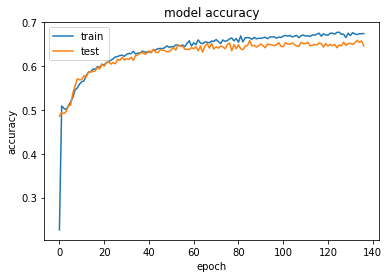

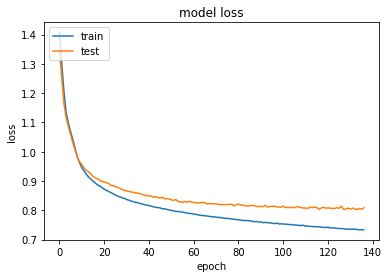

0.6461418271064758
0.6593920588493347


In [12]:
# summerize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summerize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test data 마지막 정확도
print(history.history['val_accuracy'][-1])
# test data 가장 높은 정확도
print(np.max(history.history['val_accuracy']))

## 예측

In [13]:
# 학습된 모델인 mip_function에 test 데이터를 입력하면 model이 예측한 event03 유무가 나옵니다.
# 해당 유무를 실제 event03유무와 비교하여 출력합니다.
y_pred = mip_function.predict(tstx, batch_size=40)
a = 0
b = 0
c = 0
d = 0
e = 0
f = 0
g = 0
h = 0
k = 0
l = 0
m = 0
n = 0
o = 0
p = 0
s = 0
t = 0

for i in range(len(y_pred[:,0])) :
    if y_pred[i,:].argmax() == 0: # event02, 03 발생 X
        if tsty[i,0] == 1 :
            a = a + 1
        elif tsty[i,1] == 1 :
            b = b + 1
        elif tsty[i,2] == 1 :
            c = c + 1
        elif tsty[i,3] == 1 :
            d = d + 1
    elif y_pred[i,:].argmax() == 1: # event02 발생 
        if tsty[i,0] == 1 :
            e = e + 1
        elif tsty[i,1] == 1 :
            f = f + 1
        elif tsty[i,2] == 1 :
            g = g + 1
        elif tsty[i,3] == 1 :
            h = h + 1
    elif y_pred[i,:].argmax() == 2: # event03 발생
        if tsty[i,0] == 1 :
            k = k + 1
        elif tsty[i,1] == 1 :
            l = l + 1
        elif tsty[i,2] == 1 :
            m = m + 1
        elif tsty[i,3] == 1 :
            n = n + 1
    elif y_pred[i,:].argmax() == 3: # event10 발생
        if tsty[i,0] == 1 :
            o = o + 1
        elif tsty[i,1] == 1 :
            p = p + 1
        elif tsty[i,2] == 1 :
            s = s + 1
        elif tsty[i,3] == 1 :
            t = t + 1

print("예측 : 0")
print("실제 : 0 -> ", a)
print("실제 : 1 -> ", b)
print("실제 : 2 -> ", c)
print("실제 : 3 -> ", d)
print("---------------------")
print("예측 : 1")
print("실제 : 0 -> ", e)
print("실제 : 1 -> ", f)
print("실제 : 2 -> ", g)
print("실제 : 3 -> ", h)
print("---------------------")
print("예측 : 2")
print("실제 : 0 -> ", k)
print("실제 : 1 -> ", l)
print("실제 : 2 -> ", m)
print("실제 : 3 -> ", n)
print("---------------------")
print("예측 : 3")
print("실제 : 0 -> ", o)
print("실제 : 1 -> ", p)
print("실제 : 2 -> ", s)
print("실제 : 3 -> ", t)
print("---------------------")
print("전체데이터 개수 : ", len(y_pred[:,0]))
print((a+f+m+t)/len(y_pred[:,0]))

예측 : 0
실제 : 0 ->  509
실제 : 1 ->  115
실제 : 2 ->  70
실제 : 3 ->  29
---------------------
예측 : 1
실제 : 0 ->  30
실제 : 1 ->  81
실제 : 2 ->  31
실제 : 3 ->  6
---------------------
예측 : 2
실제 : 0 ->  60
실제 : 1 ->  39
실제 : 2 ->  166
실제 : 3 ->  11
---------------------
예측 : 3
실제 : 0 ->  32
실제 : 1 ->  8
실제 : 2 ->  23
실제 : 3 ->  73
---------------------
전체데이터 개수 :  1283
0.6461418550272798
